## _*H2 ground state energy computation using Iterative QPE*_

This notebook demonstrates computing and graphing the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using `IQPE` (Iterative Quantum Phase Estimation) algorithm. It is compared to the ground-truth energies as computed by the `NumPyMinimumEigensolver`.

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

First we define the `compute_energy` method, which contains the H2 molecule definition as well as the computation of its ground energy given the desired `distance` and `algorithm` (`i` is just a helper index for parallel computation to speed things up).

Note that varying `num_iterations` (obviously) changes the result significantly. 

In [1]:
import time
import pylab
import concurrent.futures
import multiprocessing as mp
import numpy as np
from scipy.linalg import expm

from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Z2Symmetries
from qiskit.circuit.library import UnitaryGate
from qiskit_aer.primitives import Sampler

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import IterativePhaseEstimation

In [19]:
def compute_energy(i, distance, algorithm):
    driver = PySCFDriver(
        atom=f'H .0 .0 .0; H .0 .0 {distance}',
        unit=DistanceUnit.ANGSTROM,
        charge=0,
        spin=0,
        basis='sto3g'
    )

    molecule = driver.run()
    mapper = ParityMapper(num_particles=molecule.num_particles)
    fer_op = molecule.hamiltonian.second_q_op()
    tapered_mapper = molecule.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(fer_op)

    if algorithm == 'NumPyMinimumEigensolver':
        algo = NumPyMinimumEigensolver()
        algo.filter_criterion = molecule.get_default_filter_criterion()
        solver = GroundStateEigensolver(mapper, algo)
        result = solver.solve(molecule)
        gs_energy = result.total_energies[0]
        
    elif algorithm == 'IQPE':
        num_iterations = 12
        state_in = HartreeFock(molecule.num_spatial_orbitals, molecule.num_particles, tapered_mapper)
        sampler = Sampler()
        iqpe = IterativePhaseEstimation(num_iterations, sampler)
        U = UnitaryGate(expm(1j*qubit_op.to_matrix()))
        result = 2 * np.pi * (iqpe.estimate(U, state_in).phase - 1)
        gs_energy = result + molecule.nuclear_repulsion_energy
    else:
        raise ValueError(f'Unrecognized algorithm: {algorithm}')
    #print(f'step {i} with {algorithm} completed\n')
    return i, distance, gs_energy

In [20]:
algorithms = ['IQPE', 'NumPyMinimumEigensolver']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
distances = np.empty(steps+1)

start_time = time.time()
max_workers = max(4, mp.cpu_count())

with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for j in range(len(algorithms)):
        algorithm = algorithms[j]
        for i in range(steps+1):
            d = start + i*by/steps
            future = executor.submit(
                compute_energy, 
                i, 
                d, 
                algorithm
            )
            futures.append(future)
        for future in concurrent.futures.as_completed(futures):
            i, d, energy = future.result()
            energies[j][i] = energy
            distances[i] = d


""" for j in range(len(algorithms)):
    algorithm = algorithms[j]
    for i in range(steps+1):
        d = start + i*by/steps
        i, d, energy = compute_energy(i, d, algorithm)
        energies[j][i] = energy
        distances[i] = d
 """
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)

print("--- %s seconds ---" % (time.time() - start_time))

 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.0554711  -1.07518932 -1.09185989 -1.10608043 -1.11681495 -1.12448177
  -1.12943487 -1.13350975 -1.13543087 -1.13695502 -1.13674131 -1.13649191
  -1.13481999 -1.13185487 -1.12771065 -1.12402239 -1.12087992 -1.11682938
  -1.11194245 -1.10628349 -1.10144437]
 [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601 -1.12416092
  -1.12990478 -1.13382622 -1.13618945 -1.13722138 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]]
--- 8.661420583724976 seconds ---


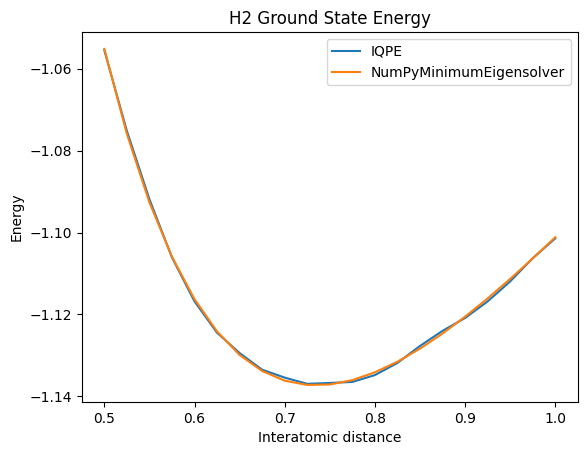

In [21]:
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')
pylab.show()